In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df1 = pd.read_csv("../Data/data1.csv")
df2 = pd.read_csv("../Data/data2.csv")

# Prepare data
X1 = df1.loc[:, 'X1':'X24']
X1 = X1.drop(columns=['X13', 'X15', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23'])
y1 = df1['Y(1=default, 0=non-default)']
X2 = df2.loc[:, 'X1':'X14']
y2 = df2['Y(1=default, 0=non-default)']

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

#### 需要单独再对data2训练一个模型

100%|██████████| 700/700 [00:00<00:00, 3922.65it/s]


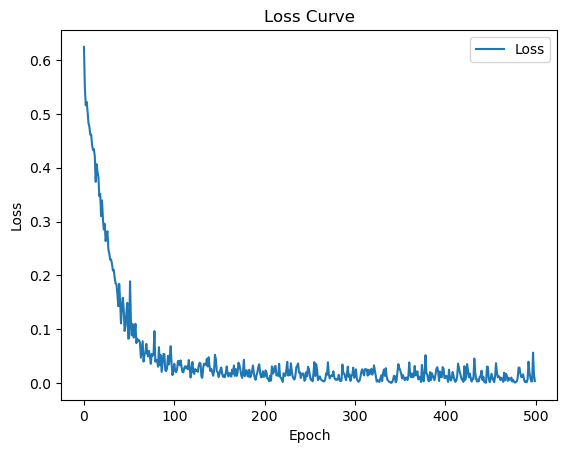

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class BPNN_CBCE(nn.Module):
    def __init__(self, input_features, output_features):
        super(BPNN_CBCE, self).__init__()
        # Define the architecture with 5 hidden layers, each having 256 neurons
        self.fc1 = nn.Linear(input_features, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.output_layer = nn.Linear(256, output_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.relu(self.fc5(x))
        x = self.output_layer(x)
        return x

def train_model(model, criterion, optimizer, train_loader, epochs=500, history=None):
    # Training loop
    model.train()
    if history is None:
        history = {'loss': []}
    for epoch in range(epochs):
        with tqdm(total=len(train_loader.dataset)) as pbar:  # 使用数据集的总长度   
            running_loss = 0.0
            for data, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                # 更新进度条
                pbar.update(data.size(0))  # 更新进度，data.size(0)是当前批次的大小
                running_loss += loss.item()
            
            epoch_loss = running_loss / len(train_loader)
            history['loss'].append(epoch_loss)
            
            # 每隔一定轮次打印损失
            if epoch % 50 == 0:
                pbar.set_description(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
    return history


def evaluate_model_with_metrics(model, test_loader, y_test):
    # Evaluation loop
    model.eval()
    outputs_all = torch.empty(0).to(y_test.device)
    labels_all = torch.empty(0).to(y_test.device)
    
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            outputs_all = torch.cat((outputs_all, outputs), 0)
            labels_all = torch.cat((labels_all, labels), 0)
    
    _, predicted = torch.max(outputs_all, 1)
    
    # Calculate metrics
    fpr, tpr, thresholds = roc_curve(y_test.cpu().numpy(), outputs_all[:, 1].cpu().numpy())
    roc_auc = auc(fpr, tpr)
    
    # Confusion matrix
    cm = confusion_matrix(y_test.cpu().numpy(), predicted.cpu().numpy())
    
    # Classification report
    report = classification_report(y_test.cpu().numpy(), predicted.cpu().numpy())
    
    # Print metrics
    print(f'Accuracy: {100 * (cm[1, 1] / np.sum(cm))}%')
    print(f'AUC-ROC: {roc_auc:.2f}')
    print(f'Confusion Matrix:\n{cm}')
    print(f'Classification Report:\n{report}')

    # Optionally plot the ROC curve
    plt.figure()
    lw = 2

    # 需要蔺经纬同志调配色！
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    # 需要蔺经纬同志调配色！

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('../Data/roc_curve.png')
    plt.show()

# Example usage
input_features = 15  # Set to the number of your input features
output_features = 2  # Set for binary classification (change if necessary)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Data preparation (dummy data)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model, loss, and optimizer setup
model = BPNN_CBCE(input_features, output_features)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train the model and keep track of the loss
history = train_model(model, criterion, optimizer, train_loader, epochs=500)

# plt.figure(figsize=(20, 17))
# Plot the loss curve

# 需要蔺经纬同志调配色！
plt.plot(history['loss'], label='Loss')
# 需要蔺经纬同志调配色！

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.savefig('../Data/loss_curve.png')
plt.show()



Accuracy: 13.0%
AUC-ROC: 0.68
Confusion Matrix:
[[171  38]
 [ 52  39]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       209
           1       0.51      0.43      0.46        91

    accuracy                           0.70       300
   macro avg       0.64      0.62      0.63       300
weighted avg       0.69      0.70      0.69       300



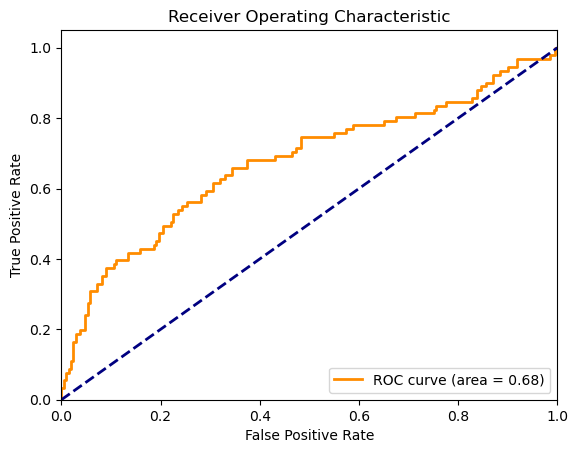

In [3]:
evaluate_model_with_metrics(model, test_loader, y_test)